In [27]:
category = ['low', 'mid', 'high'][0]
SM_RDst = 0.33
version = 'v0'
reTrain = False
plotLoss = True

# Import

In [2]:
import sys, os, pickle, time
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
from categoriesDef import categories
cat = categories[category]
import json, yaml

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from array import array
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from pT_calibration_reader import pTCalReader
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist
from gridVarQ2Plot import plot_gridVarQ2, plot_SingleCategory
from progressBar import ProgressBar

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "       Simulation Preliminary"

Welcome to JupyROOT 6.20/07


In [4]:
#They all have to be produced with the same pileup
MCsample = {
'tau' : DSetLoader('B0_TauNuDmst_PUc0'),
'mu' : DSetLoader('B0_MuNuDmst_PUc0'),
'DstmD0' : DSetLoader('B0_DstmD0_PUc0'),
'DstmDp' : DSetLoader('B0_DstmDp_PUc0'),
'DstmDsp' : DSetLoader('B0_DstmDsp_PUc0'),
'BpDstmHc' : DSetLoader('Bp_DstmHc_PUc0'),
'BmDstmHc' : DSetLoader('Bm_DstmHc_PUc0'),
'antiB0DstmHc' : DSetLoader('antiB0_DstmHc_PUc0'),
'DstPip' : DSetLoader('Bp_MuNuDstst_Pip_PUc0'),
'DstPi0' : DSetLoader('B0_MuNuDstst_Pi0_PUc0'),
'DstPipPi0' : DSetLoader('Bp_MuNuDstst_PipPi0_PUc0'),
'DstPipPim' : DSetLoader('B0_MuNuDstst_PipPim_PUc0'),
'DstPi0Pi0' : DSetLoader('B0_MuNuDstst_Pi0Pi0_PUc0'),
}
processOrder = ['tau', 'mu', 'DstPip','DstPi0','DstPipPi0','DstPipPim','DstPi0Pi0','DstmDsp','DstmD0','DstmDp','BpDstmHc','BmDstmHc','antiB0DstmHc']
dSet = {}
for n, s in MCsample.iteritems():
    if not n in processOrder: raise
    dSet[n] = rtnp.root2array(s.skimmed_dir + '/{}_corr.root'.format(cat.name))

../lib/analysis_utilities.py:115: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  samples = yaml.load(open(sampleFile))['samples']
../lib/analysis_utilities.py:143: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.effMCgen = yaml.load(open(effMCgenFile, 'r'))
../lib/analysis_utilities.py:147: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.effCand = yaml.load(open(effCandFile, 'r'))


In [5]:
expectedLumi = {'low':6.4, 'mid':20.7, 'high':26.4, 'single':6.} #fb^-1
lumi_tot = expectedLumi[category]
CMS_lumi.integrated_lumi = lumi_tot

# Load corrections

In [6]:
from pileup_utilities import pileupReweighter
puReweighter = pileupReweighter(MCsample['mu'].skimmed_dir + '/{}_corr.root'.format(cat.name), cat)

In [7]:
decayBR = pickle.load(open('../data/forcedDecayChannelsFactors.pickle', 'rb'))

In [8]:
loc = '../data/calibration/triggerScaleFactors/'
fTriggerSF = rt.TFile.Open(loc + 'HLT_' + cat.trg + '_SF_v3.root', 'READ')
hTriggerSF = fTriggerSF.Get('hSF_HLT_' + cat.trg)

def computeTrgSF(ds, selection=None):
    trgSF = np.ones_like(ds['q2'])
    trgSFUnc = np.zeros_like(ds['q2'])
    ptmax = hTriggerSF.GetXaxis().GetXmax() - 0.01
    ipmax = hTriggerSF.GetYaxis().GetXmax() - 0.01
    etamax = hTriggerSF.GetZaxis().GetXmax() - 0.01
    x = np.column_stack((ds['mu_pt'], ds['mu_eta'], ds['mu_sigdxy']))
    if not selection is None:
        x = x[selection]
    for i, (pt, eta, ip) in enumerate(x):
        ix = hTriggerSF.GetXaxis().FindBin(min(ptmax, pt))
        iy = hTriggerSF.GetYaxis().FindBin(min(ipmax, ip))
        iz = hTriggerSF.GetZaxis().FindBin(min(etamax, np.abs(eta)))
        trgSF[i] = hTriggerSF.GetBinContent(ix, iy, iz)
        if trgSF[i] == 0:
            print pt, ip, np.abs(eta)
            raise
    return trgSF

In [9]:
fMuonIDSF = rt.TFile.Open('../data/calibration/muonIDscaleFactors/Run2018ABCD_SF_MuonID_Jpsi.root', 'READ')
hMuonIDSF = fMuonIDSF.Get('NUM_SoftID_DEN_genTracks_pt_abseta')

def computeMuonIDSF(ds, selection=None):
    muonSF = np.ones_like(ds['q2'])
    muonSFUnc = np.zeros_like(ds['q2'])
    ptmax = hMuonIDSF.GetXaxis().GetXmax() - 0.01
    etamax = hMuonIDSF.GetYaxis().GetXmax() - 0.01
    x = np.column_stack((ds['MC_mu_pt'], ds['MC_mu_eta']))
    if not selection is None:
        x = x[selection]
    for i, (pt, eta) in enumerate(x):
        ix = hMuonIDSF.GetXaxis().FindBin(min(pt, ptmax))
        if ix == 0: ix = 1 #Remove underflows (Meaning that the MC matching failed)
        iy = hMuonIDSF.GetYaxis().FindBin(min(np.abs(eta), etamax))
        muonSF[i] = hMuonIDSF.GetBinContent(ix, iy)
        if muonSF[i] == 0:
            print pt, eta
            print ix, iy
            raise
    return muonSF

In [10]:
cal_pT = pTCalReader(calibration_file='../data/calibration/B0pTspectrum/pwWeights_{}.txt'.format(cat.name))

# Create dataset

In [11]:
sampleWeights = {}
sampleX = {}

RDoMC_normRatio = 2.5 # Ad hoc overall scale corr
for n in processOrder:
    print '\n----------->', n, '<-------------'
    ds = dSet[n]
    sMC = MCsample[n]
    
    nTotSelected = ds['q2'].shape[0]
    print 'N tot selected: {:.1f}k'.format(1e-3*nTotSelected)
    nGenExp = sMC.effMCgen['xsec'][0] * lumi_tot * RDoMC_normRatio
    if n == 'tau':
        nGenExp *= SM_RDst
    eff = [1, 0]
    for f, df in [sMC.effMCgen['effGEN'], decayBR[n], sMC.effCand['effCAND'], sMC.getSkimEff(cat.name+'_corr')]:
        eff[0] *= f
        eff[1] += np.square(df/f)
    eff[1] = eff[0] * np.sqrt(eff[1])
    nTotExp = nGenExp*eff[0]
    print 'N tot expected (before weights): {:.2f}k'.format(1e-3*nTotExp)
    
    weightsCentral = puReweighter.weightsPileupMC[ds['N_vtx'].astype(np.int)]
    weightsCentral *= computeTrgSF(ds)
    weightsCentral *= computeMuonIDSF(ds)
    if n in ['mu', 'tau', 'DstmD0', 'DstmDp', 'DstmDsp','DstPi0', 'DstPipPim', 'DstPi0Pi0']: #B0 dominated final states (probably we should do something about B+ too)
        weightsCentral *= cal_pT.f['C'](ds['MC_B_pt'])
    if n in ['mu', 'tau']:
        weightsCentral *= ds['wh_CLNCentral']*sMC.effCand['rate_den']/sMC.effCand['rate_Central']
    weightsCentral *= nTotExp/nTotSelected
    print 'N tot expected (after weights): {:.3f}k'.format(1e-3*np.sum(weightsCentral))
    sampleWeights[n] = weightsCentral
    sampleX[n] = np.column_stack((ds['q2'], ds['Est_mu'], ds['M2_miss']))
del dSet


-----------> tau <-------------
N tot selected: 61.3k
N tot expected (before weights): 1.91k
N tot expected (after weights): 2.167k

-----------> mu <-------------
N tot selected: 594.9k
N tot expected (before weights): 113.45k
N tot expected (after weights): 119.291k

-----------> DstPip <-------------
N tot selected: 36.7k
N tot expected (before weights): 3.82k
N tot expected (after weights): 4.077k

-----------> DstPi0 <-------------
N tot selected: 49.3k
N tot expected (before weights): 4.78k
N tot expected (after weights): 5.276k

-----------> DstPipPi0 <-------------
N tot selected: 3.4k
N tot expected (before weights): 0.38k
N tot expected (after weights): 0.395k

-----------> DstPipPim <-------------
N tot selected: 2.0k
N tot expected (before weights): 0.27k
N tot expected (after weights): 0.281k

-----------> DstPi0Pi0 <-------------
N tot selected: 23.3k
N tot expected (before weights): 0.49k
N tot expected (after weights): 0.549k

-----------> DstmDsp <-------------
N tot 

# Exploratory Plots

In [12]:
weightsBkg = np.array([])
xBkg = np.zeros((0,3))
for n in sampleWeights.keys():
    if not n in ['tau', 'mu']:
        weightsBkg = np.concatenate((weightsBkg, sampleWeights[n]))
        xBkg = np.concatenate((xBkg, sampleX[n]))

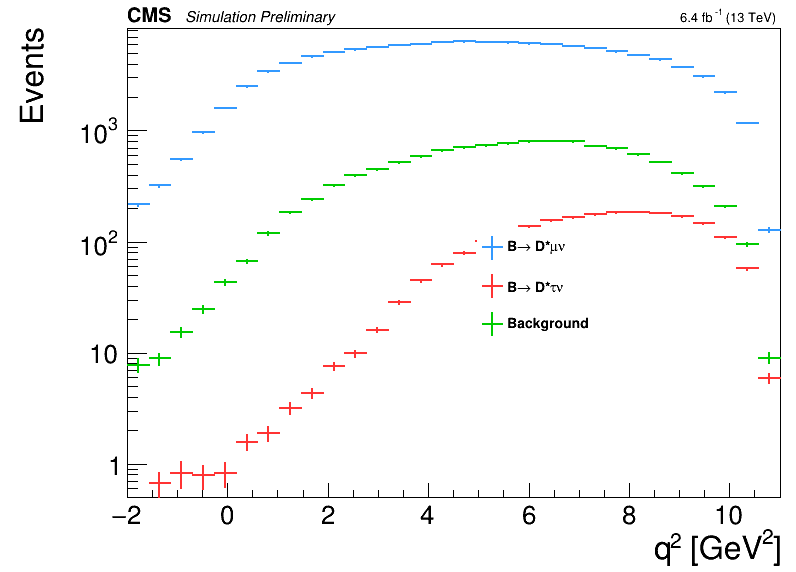

In [13]:
#q2
leg = rt.TLegend(0.6, 0.4, 0.75, 0.6)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

hl = []
h = create_TH1D(sampleX['mu'][:, 0], weights=sampleWeights['mu'],
                binning=[30,-2,11.], color=0, axis_title=['q^{2} [GeV^{2}]', 'Events'])
hl.append(h)
leg.AddEntry(h, 'B#rightarrow D*#mu#nu', 'lep')

h = create_TH1D(sampleX['tau'][:, 0], weights=sampleWeights['tau'], binning=hl[0].binning, color=1)
hl.append(h)
leg.AddEntry(h, 'B#rightarrow D*#tau#nu', 'lep')

h = create_TH1D(xBkg[:, 0], weights=weightsBkg, binning=hl[0].binning, color=2)
hl.append(h)
leg.AddEntry(h, 'Background', 'lep')


m = SetMaxToMaxHist(hl)
hl[0].GetYaxis().SetRangeUser(0.5, m*1.2)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
c.SetLogy()
leg.Draw()

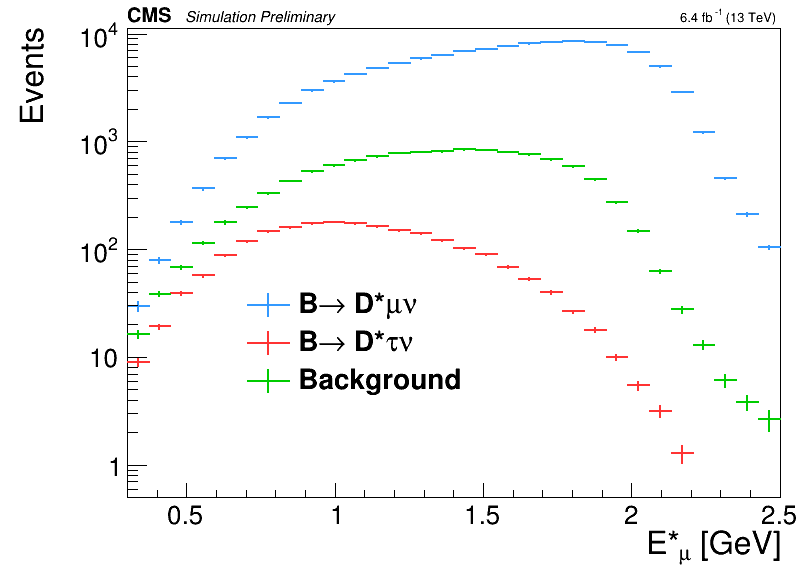

In [14]:
#Est_mu
leg = rt.TLegend(0.3, 0.3, 0.6, 0.5)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

hl = []
h = create_TH1D(sampleX['mu'][:, 1], weights=sampleWeights['mu'],
                binning=[30,0.3,2.5], color=0, axis_title=['E*_{#mu} [GeV]', 'Events'])
hl.append(h)
leg.AddEntry(h, 'B#rightarrow D*#mu#nu', 'lep')

h = create_TH1D(sampleX['tau'][:, 1], weights=sampleWeights['tau'], binning=hl[0].binning, color=1)
hl.append(h)
leg.AddEntry(h, 'B#rightarrow D*#tau#nu', 'lep')

h = create_TH1D(xBkg[:, 1], weights=weightsBkg, binning=hl[0].binning, color=2)
hl.append(h)
leg.AddEntry(h, 'Background', 'lep')


m = SetMaxToMaxHist(hl)
hl[0].GetYaxis().SetRangeUser(0.5, m*1.2)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
c.SetLogy()
leg.Draw()

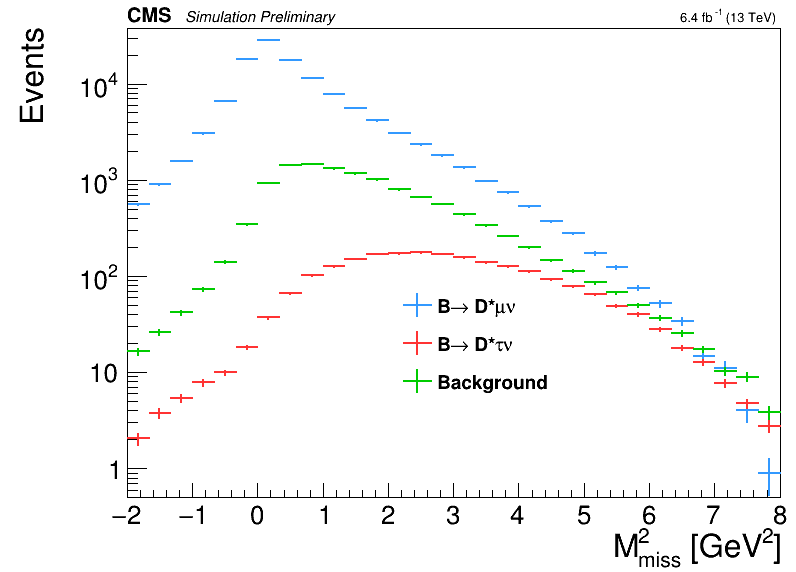

In [15]:
#M2miss
leg = rt.TLegend(0.5, 0.3, 0.7, 0.5)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

hl = []
h = create_TH1D(sampleX['mu'][:, 2], weights=sampleWeights['mu'],
                binning=[30,-2,8], color=0, axis_title=['M^{2}_{miss} [GeV^{2}]', 'Events'])
hl.append(h)
leg.AddEntry(h, 'B#rightarrow D*#mu#nu', 'lep')

h = create_TH1D(sampleX['tau'][:, 2], weights=sampleWeights['tau'], binning=hl[0].binning, color=1)
hl.append(h)
leg.AddEntry(h, 'B#rightarrow D*#tau#nu', 'lep')

h = create_TH1D(xBkg[:, 2], weights=weightsBkg, binning=hl[0].binning, color=2)
hl.append(h)
leg.AddEntry(h, 'Background', 'lep')


m = SetMaxToMaxHist(hl)
hl[0].GetYaxis().SetRangeUser(0.5, m*1.2)
c = drawOnCMSCanvas(CMS_lumi, hl, 'same')
c.SetLogy()
leg.Draw()

In [16]:
np.set_printoptions(precision=2)
print 'Mu\n', np.corrcoef(sampleX['mu'].T)
print '\n\n'
print 'Tau\n', np.corrcoef(sampleX['tau'].T)
print '\n\n'
print 'Bkg\n', np.corrcoef(xBkg.T)

Mu
[[ 1.   -0.03  0.37]
 [-0.03  1.   -0.5 ]
 [ 0.37 -0.5   1.  ]]



Tau
[[ 1.   -0.11  0.58]
 [-0.11  1.   -0.71]
 [ 0.58 -0.71  1.  ]]



Bkg
[[ 1.   -0.14  0.59]
 [-0.14  1.   -0.71]
 [ 0.59 -0.71  1.  ]]


In [17]:
legendTxt = ['B#rightarrow D*#mu#nu', 'B#rightarrow D*#tau#nu', 'Background']
l = rt.TLatex()
l.SetTextAlign(11)
l.SetTextSize(0.05)
l.SetTextFont(42)

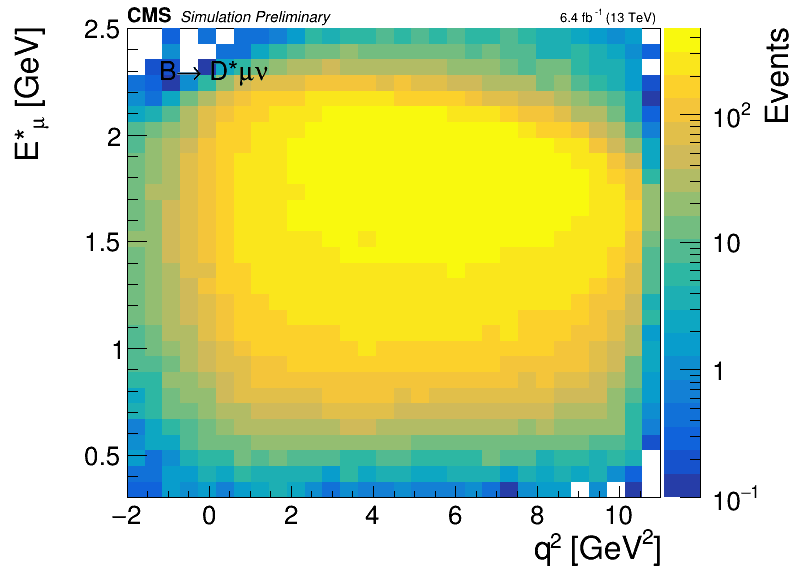

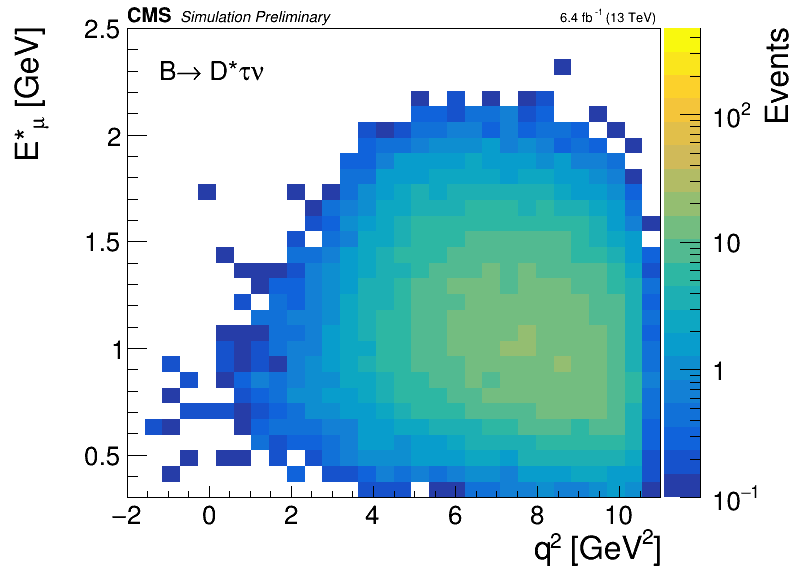

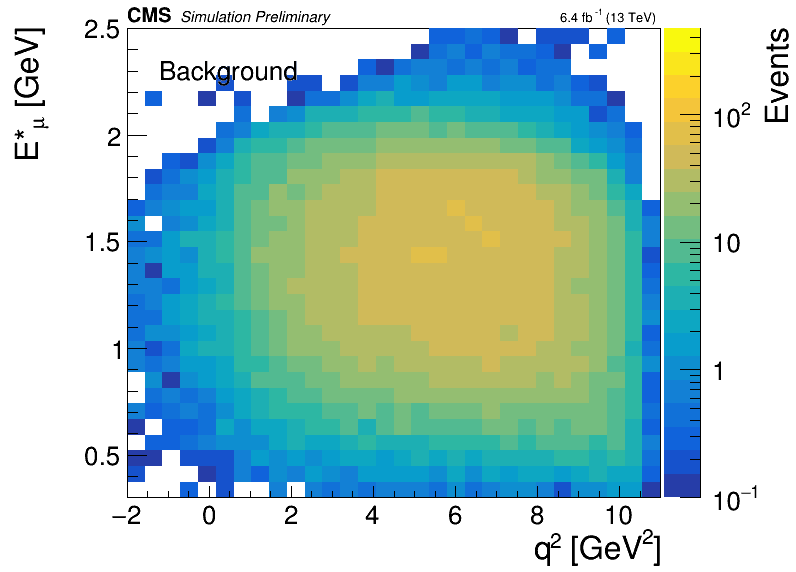

In [18]:
#q2 vs Est_mu
hl = []
h = create_TH2D(sampleX['mu'][:, 0:2], weights=sampleWeights['mu'],
                binning=[30, -2, 11, 30, 0.3, 2.5], axis_title=['q^{2} [GeV^{2}]', 'E*_{#mu} [GeV]', 'Events'])
hl.append(h)

h = create_TH2D(sampleX['tau'][:, 0:2], weights=sampleWeights['tau'], 
                binning=hl[0].binning, axis_title=h.axis_title)
hl.append(h)

h = create_TH2D(xBkg[:, 0:2], weights=weightsBkg, 
                binning=hl[0].binning, axis_title=h.axis_title)
hl.append(h)

M = np.max([h.GetMaximum() for h in hl])
for h in hl:
    h.GetZaxis().SetRangeUser(0.1, M)

for i, h in enumerate(hl):
    c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag=str(i), mR=0.17)
    c.Draw()
    c.SetLogz()
    l.DrawLatexNDC(0.2, 0.86, legendTxt[i])

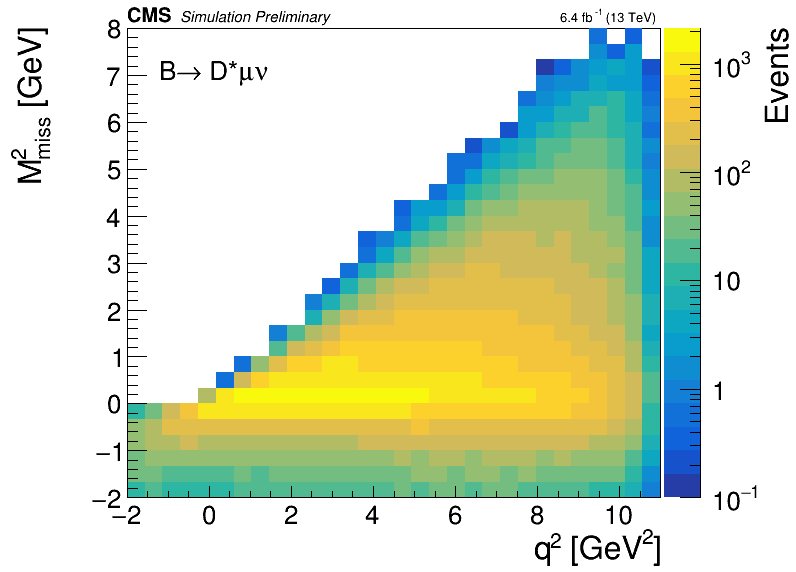

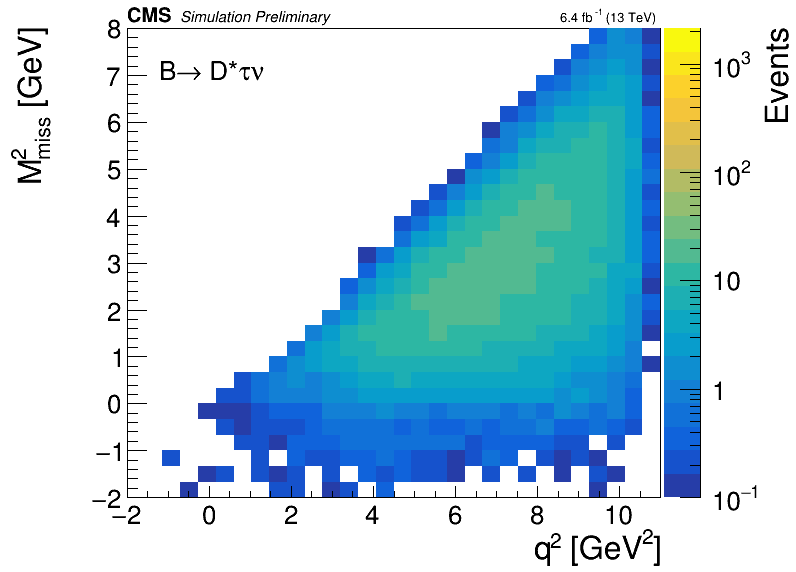

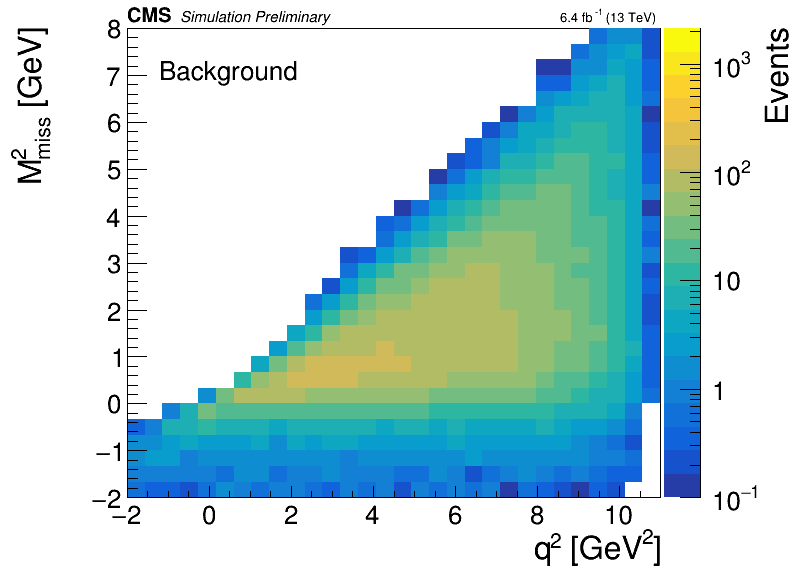

In [19]:
#q2 vs M2miss
hl = []
h = create_TH2D(sampleX['mu'][:, np.array([0,2])], weights=sampleWeights['mu'],
                binning=[30, -2, 11, 30,-2,8], axis_title=['q^{2} [GeV^{2}]', 'M^{2}_{miss} [GeV]', 'Events'])
hl.append(h)

h = create_TH2D(sampleX['tau'][:, np.array([0,2])], weights=sampleWeights['tau'], 
                binning=hl[0].binning, axis_title=h.axis_title)
hl.append(h)

h = create_TH2D(xBkg[:, np.array([0,2])], weights=weightsBkg, 
                binning=hl[0].binning, axis_title=h.axis_title)
hl.append(h)

M = np.max([h.GetMaximum() for h in hl])
for h in hl:
    h.GetZaxis().SetRangeUser(0.1, M)

for i, h in enumerate(hl):
    c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag=str(i), mR=0.17)
    c.Draw()
    c.SetLogz()
    l.DrawLatexNDC(0.2, 0.86, legendTxt[i])

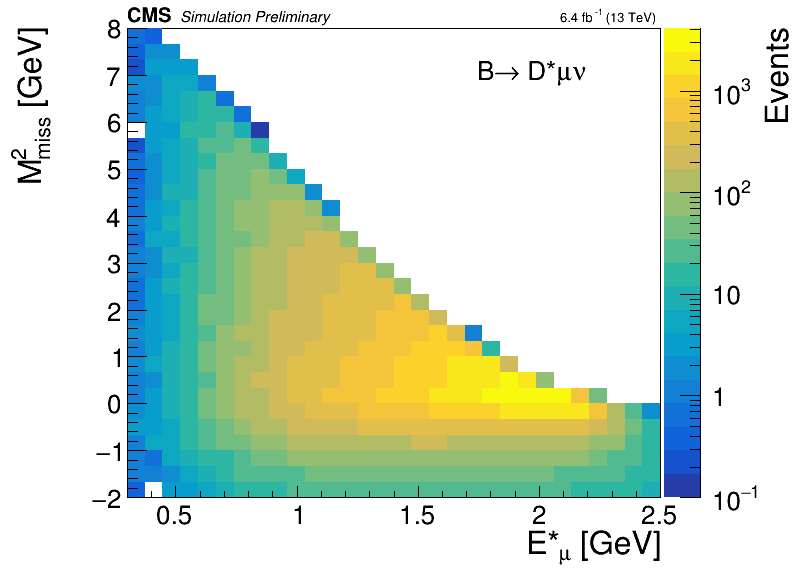

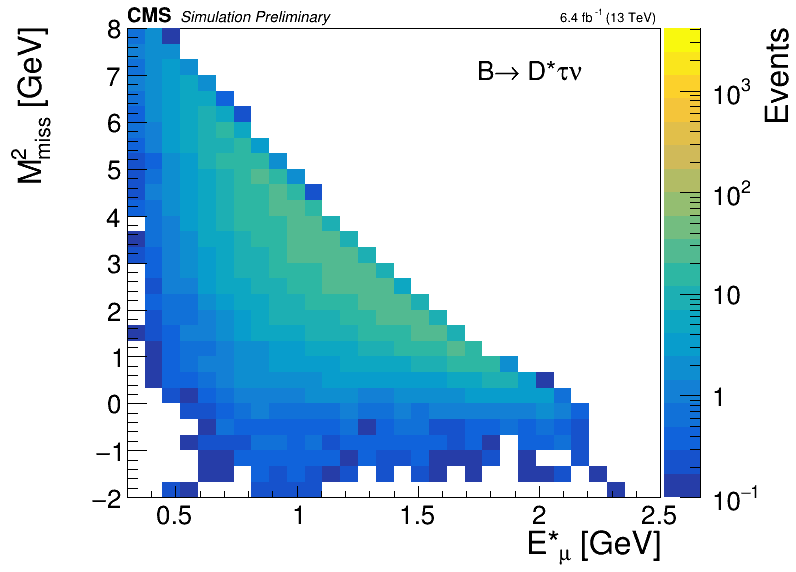

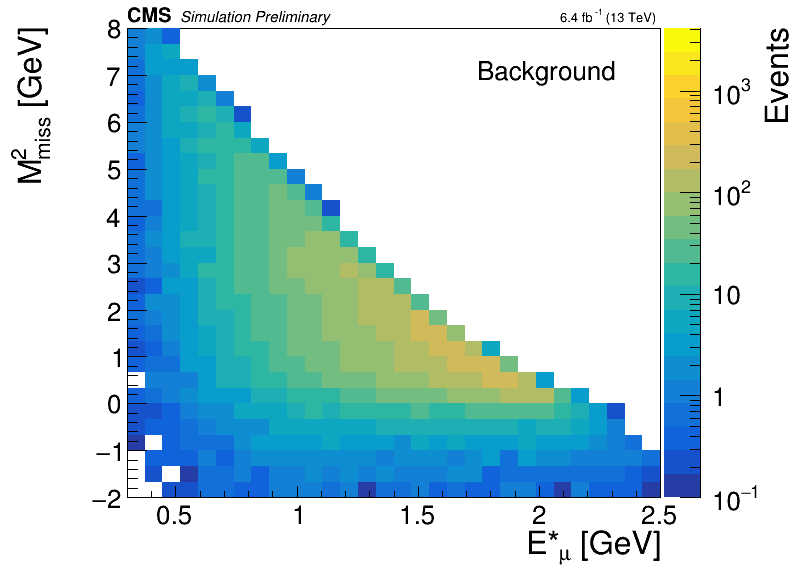

In [20]:
#Estmu vs M2miss
hl = []
h = create_TH2D(sampleX['mu'][:, np.array([1,2])], weights=sampleWeights['mu'],
                binning=[30, 0.3, 2.5, 30,-2,8], axis_title=['E*_{#mu} [GeV]', 'M^{2}_{miss} [GeV]', 'Events'])
hl.append(h)

h = create_TH2D(sampleX['tau'][:, np.array([1,2])], weights=sampleWeights['tau'], 
                binning=hl[0].binning, axis_title=h.axis_title)
hl.append(h)

h = create_TH2D(xBkg[:, np.array([1,2])], weights=weightsBkg, 
                binning=hl[0].binning, axis_title=h.axis_title)
hl.append(h)

M = np.max([h.GetMaximum() for h in hl])
for h in hl:
    h.GetZaxis().SetRangeUser(0.1, M)

for i, h in enumerate(hl):
    c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag=str(i), mR=0.17)
    c.Draw()
    c.SetLogz()
    l.DrawLatexNDC(0.6, 0.86, legendTxt[i])

# Two samples splitting (Tau vs All)

In [21]:
# weightsBkg = np.array([])
# xBkg = np.zeros((0,3))
# for n in sampleWeights.keys():
#     if not n == 'tau':
#         weightsBkg = np.concatenate((weightsBkg, sampleWeights[n]))
#         xBkg = np.concatenate((xBkg, sampleX[n]))

# wTot = np.sum(weightsBkg) + np.sum(sampleWeights['tau'])
# fBkg = np.sum(weightsBkg)/wTot
# fSig = np.sum(sampleWeights['tau'])/wTot
# print fBkg
# print fSig

In [22]:
weightsBkg = np.array([])
xBkg = np.zeros((0,3))
for n in sampleWeights.keys():
    if not n in ['tau', 'mu']:
        weightsBkg = np.concatenate((weightsBkg, sampleWeights[n]))
        xBkg = np.concatenate((xBkg, sampleX[n]))

wTot = np.sum(weightsBkg) + np.sum(sampleWeights['tau']) + np.sum(sampleWeights['mu'])
fBkg = np.sum(weightsBkg)/wTot
fTau = np.sum(sampleWeights['tau'])/wTot
fMu = np.sum(sampleWeights['mu'])/wTot
print fTau, fMu, fBkg

0.01625697409967683 0.8948110924684591 0.08893193343186395


In [23]:
X = np.concatenate((xBkg, sampleX['tau'], sampleX['mu']))
weights = np.concatenate((weightsBkg/fBkg, sampleWeights['tau']/fTau, sampleWeights['mu']/fMu))

yBkg = np.zeros_like(weightsBkg)
yMu = np.zeros_like(sampleWeights['mu'])
yTau = np.ones_like(sampleWeights['tau'])
y = np.concatenate((yBkg, yTau, yMu))

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.1, random_state=0)

## BDT Classifier

In [24]:
fname = './kinObsMVA/clfGBC_tauVall_{}{}.p'.format(version, cat.name)
if reTrain or not os.path.exists(fname):
    clfGBC = GradientBoostingClassifier(
        learning_rate=0.0005, 
        n_estimators=100000, 
        min_samples_split=5, 
        min_weight_fraction_leaf=5e-4, 
        max_depth=3,
        validation_fraction=0.20,
        n_iter_no_change=250,
        tol=0.00001,
#         ccp_alpha=1e-4,
        verbose=2,
        random_state=0
    )

    clfGBC.fit(X_train, y_train, sample_weight=w_train)
    pickle.dump(clfGBC, open(fname, 'wb')) 
else:
    clfGBC = pickle.load(open(fname, 'rb'))
    
sTrain = clfGBC.score(X_train, y_train, sample_weight=w_train)
sTest = clfGBC.score(X_test, y_test, sample_weight=w_test)
print 'Accuracy: {:.5f} (train), {:.5f} (test)'.format(sTrain, sTest)
print 'Feature importance:', clfGBC.feature_importances_

Accuracy: 0.75873 (train), 0.75339 (test)
[0.06 0.06 0.88]


In [28]:
if plotLoss:
    test_deviance = np.zeros((50000,), dtype=np.float64)
    train_deviance = np.zeros((50000,), dtype=np.float64)

    for i, y_pred in enumerate(clfGBC.staged_decision_function(X_test)):
        test_deviance[i] = clfGBC.loss_(y_test, y_pred)
    test_deviance = test_deviance[test_deviance > 0]
    for i, y_pred in enumerate(clfGBC.staged_decision_function(X_train)):
        train_deviance[i] = clfGBC.loss_(y_train, y_pred)
    train_deviance = train_deviance[train_deviance > 0]

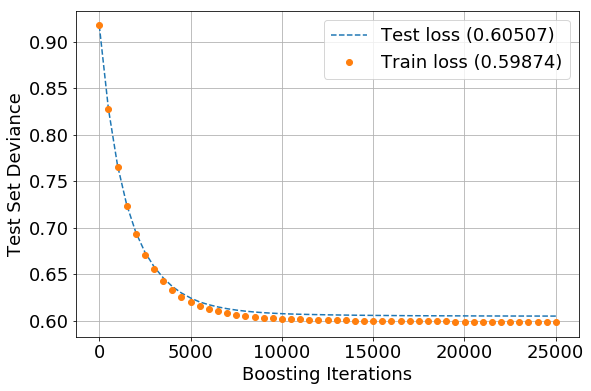

In [31]:
if plotLoss:
    plotEvery = 500
    plt.rcParams.update({'font.size': 18})
    fig = plt.figure(figsize=(9,6))
    plt.plot((np.arange(test_deviance.shape[0]) + 1)[::plotEvery], test_deviance[::plotEvery], '--', label='Test loss ({:.5f})'.format(test_deviance[-1]))
    plt.plot((np.arange(train_deviance.shape[0]) + 1)[::plotEvery], train_deviance[::plotEvery], 'o', label='Train loss ({:.5f})'.format(train_deviance[-1]))
    plt.legend(loc='best')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Test Set Deviance')
#     plt.yscale('log')
    plt.grid()
    plt.show()
    fig.savefig('./kinObsMVA/trainHistory_clfGBC_tauVall_{}{}.png'.format(version, cat.name))

In [ ]:
xq2 = np.arange(-1.9, 11.1, 0.8)
limEstMu = [0.3,2.5, 0.05]
limM2miss = [-2, 8.0, 0.05]

x = np.arange(limEstMu[0], limEstMu[1]+limEstMu[2], limEstMu[2])
x = 0.5*(x[:-1] + x[1:])
y = np.arange(limM2miss[0], limM2miss[1]+limM2miss[2], limM2miss[2])
y = 0.5*(y[:-1] + y[1:])
x2 = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
# print x.shape, y.shape, x2.shape

y, x = np.mgrid[slice(limM2miss[0], limM2miss[1]+limM2miss[2], limM2miss[2]),
                slice(limEstMu[0], limEstMu[1]+limEstMu[2], limEstMu[2])]
# print x.shape
# print y.shape

# print x
# print y
# print
# print x2[:,0].reshape(x.shape[0]-1, x.shape[1]-1)

fig, axes = plt.subplots(4,4, figsize=(18,16))
for i in range(xq2.shape[0] - 1):
# i=3
    ax = axes[i/4, i%4]

    auxq2 = 0.5*(xq2[i] + xq2[i+1])*np.ones(x2.shape[0])
    xIn = np.column_stack((auxq2, x2))
    p = clfGBC.predict_proba(xIn)
    p = p[:,1].reshape(x.shape[0]-1, x.shape[1]-1)
    c = ax.pcolorfast(x, y, p, cmap='viridis', vmin=0, vmax=1)
    fig.colorbar(c, ax=ax)
    ax.set_xlabel(r'$E^{*}_{\mu}$ [GeV]')
    ax.set_ylabel('$M^{2}_{miss}$ '+'$[GeV^2]$')
    ax.set_title('$q^2$ = '+'{:.1f} '.format(auxq2[0]) + '$GeV^2$')

fig.tight_layout(pad=1.5)
fig.savefig('./kinObsMVA/scoreMap_clfGBC_tauVall_{}{}.png'.format(version, cat.name))

In [ ]:
histos = {}
histoq2 = [{}, {}, {}, {}]
binsq2 = [-2, 2.5, 6, 9.4, 12]
predProba = {}

for n in sampleX.keys():
    print n
    p = clfGBC.predict_proba(sampleX[n])
    predProba[n] = p
    histos[n] = create_TH1D(p[:,1], name='h'+n, binning=[80, 0, 1.2], weights=sampleWeights[n],
                            axis_title=['GBC predicted probability', 'Expected events'])
    
    for i, (q2low, q2high) in enumerate(zip(binsq2[:-1], binsq2[1:])):
        sel = np.logical_and(sampleX[n][:,0] >= q2low, sampleX[n][:,0] < q2high)
        histoq2[i][n] = create_TH1D(p[:,1][sel], name='hq2'+n+str(i), binning=[60, 0, 1.2], 
                                   weights=sampleWeights[n][sel],
                                   axis_title=['GBC predicted probability', 'Expected events']
                                  )
histos['data'] = histos['mu'].Clone('placeholderData')
histos['data'].Reset()
for i, hdic in enumerate(histoq2):
    hdic['data'] = hdic['mu'].Clone('placeholderData_q2'+str(i))
    hdic['data'].Reset()

In [ ]:
c = plot_SingleCategory(CMS_lumi, histos,
                        addText='Signal Region', min_y=1, tag='log', logy=True,
                        legLoc=[0.75, 0.45, 0.92, 0.75],
                        procOrder = ['tau', 'DstD', 'Dstst', 'mu']
                       )
c.Draw()
c.SaveAs('./kinObsMVA/scores_clfGBC_tauVall_{}{}.png'.format(version, cat.name))

In [ ]:
cvs = len(histoq2)*[None]
for i, hdic in enumerate(histoq2):
    q2Text = '{:.1f} < q^{{2}} < {:.1f} GeV^{{2}}'.format(binsq2[i], binsq2[i+1])
    cvs[i] = plot_SingleCategory(CMS_lumi, hdic,
                        addText=q2Text, min_y=1, tag='logq2'+str(i), logy=True,
                        legLoc=[0.75, 0.45, 0.92, 0.75],
                        procOrder = ['tau', 'DstD', 'Dstst', 'mu']
                       )
    cvs[i].Draw()
    cvs[i].SaveAs('./kinObsMVA/scores_clfGBC_tauVall_{}{}_q2bin{}.png'.format(version, cat.name, i))

In [ ]:
C = plot_SingleCategory(CMS_lumi, histos,
                        addText='Signal Region', min_y=1, tag='lin', logy=False,
                        legLoc=[0.75, 0.45, 0.92, 0.75],
                        procOrder = ['tau', 'DstD', 'Dstst', 'mu'],
                        max_y = 1000
                       )
C.Draw()

# Three samples (Tau vs Mu vs Bkg)

In [ ]:
# weightsBkg = np.array([])
# xBkg = np.zeros((0,3))
# for n in sampleWeights.keys():
#     if not n in ['tau', 'mu']:
#         weightsBkg = np.concatenate((weightsBkg, sampleWeights[n]))
#         xBkg = np.concatenate((xBkg, sampleX[n]))

# wTot = np.sum(weightsBkg) + np.sum(sampleWeights['tau']) + np.sum(sampleWeights['mu'])
# fBkg = np.sum(weightsBkg)/wTot
# fTau = np.sum(sampleWeights['tau'])/wTot
# fMu = np.sum(sampleWeights['mu'])/wTot
# print fTau, fMu, fBkg

In [ ]:
# X = np.concatenate((xBkg, sampleX['tau'], sampleX['mu']))
# weights = np.concatenate((weightsBkg/fBkg, sampleWeights['tau']/fTau, sampleWeights['mu']/fMu))

# yBkg = 0*np.ones_like(weightsBkg)
# yMu = 1*np.ones_like(sampleWeights['mu'])
# yTau = 2*np.ones_like(sampleWeights['tau'])
# y = np.concatenate((yBkg, yTau, yMu))

In [ ]:
# X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=0)

## GBC Classifier

In [ ]:
# fname = './kinObsMVA/clfGBC_bkgVmuVtau_{}{}.p'.format(version, cat.name)
# if reTrain or not os.path.exists(fname):
#     clfGBC = GradientBoostingClassifier(
#         learning_rate=0.001, 
#         n_estimators=1000, 
#         min_samples_split=5, 
#         min_weight_fraction_leaf=1e-3, 
#         max_depth=3, 
#         verbose=1,
#         random_state=0
#     )

#     clfGBC.fit(X_train, y_train, sample_weight=w_train)

#     sTrain = clfGBC.score(X_train, y_train, sample_weight=w_train)
#     sTest = clfGBC.score(X_test, y_test, sample_weight=w_test)
#     print 'Accuracy: {:.5f} (train), {:.5f} (test)'.format(sTrain, sTest)
#     pickle.dump(clfGBC, open(fname, 'wb')) 
# else:
#     clfGBC = pickle.load(open(fname, 'rb'))

In [ ]:
# pMu = clfGBC.predict_proba(sampleX['mu'])
# pTau = clfGBC.predict_proba(sampleX['tau'])
# pBkg = clfGBC.predict_proba(xBkg)

In [ ]:
# probs = [pMu, pTau, pBkg]
# weights = [sampleWeights['mu'], sampleWeights['tau'], weightsBkg]
# tag = ['mu', 'tau', 'bkg']
# dnd = []
# for p, w, t in zip(probs, weights, tag):
#     h = create_TH2D(p[:, 1:], 
#                     binning=[50,0,1,50,0,1], 
#                     name='h2_'+t,
#                     axis_title=['GBC p(#mu)', 'GBC p(#tau)', 'Events '+t], 
#                     weights=w)
#     dnd.append(drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag='c_'+t, mR=0.2))

In [ ]:
# histos = {}
# for n in sampleX.keys():
#     p = clfGBC.predict_proba(sampleX[n])
#     histos[n] = create_TH1D(p[:,2], name='h'+n, binning=[100, 0, 1], weights=sampleWeights[n],
#                             axis_title=['GBC predicted Tau class probability', 'Expected events'])
# histos['data'] = histos['mu'].Clone('placeholderData')
# histos['data'].Reset()